In [45]:
import astropy.visualization as vis
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
import numpy as np
import urllib.request
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table
from astropy.table import hstack
from astropy.table import vstack
from astropy import wcs
from itertools import product
from scipy.stats import binned_statistic as bs
%matplotlib inline 
import seaborn as sns 
from astroML.stats import sigmaG
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=15, usetex=True)

Read in all visits,  per processing (DECAPS / LSST) . As we perform the cleaning, store ( per processing ) 
* N_sources_MAF  per visit 
* visit number 
* density 
* N sources in input catalog 
* N sources flagged due  to low S/N
* N sources flagged due to negative flux
* N sources flagged due to bad mask/flag info   
* total N sources that were considered 'bad', 
* total N sources left in the 'clean' ( per visit ) 
* total N sources left in the 'clean' (per sq.degree)
* total N sources left in the 'clean' (N_sources / arcsec_sq)*PSF units , as in Jim Bosch presentation 




In [ ]:
# First do that for all visits done earlier
visit_density_dic = {'20':[611529,609754,525814,525900],
                     '15':[611970,525837,525838],
                     '10':[611969,525846,525879],
                      '5':[525904,525920]}    

# Then for all visits considered later...
visit_info = Table.read('decaps_rms_different_epoch_fields.txt', format='ascii')


## Astrometry 

Plot dra, ddec   - use already cross-matched sources ! 



In [35]:
visit_info = Table.read('decaps_visits_epoch12.txt', format='latex')
pairs = [[visit_info['visit_1'][i],visit_info['visit_2'][i]] 
         for i in range(len(visit_info))]
#for source in ['lsst','decaps']:
for pair in pairs[:1] : 
    print(pair)
    visit1,visit2 = pair[0], pair[1]
    print('Comparing ', visit1, ' to ', visit2, ' of ', source )
    density = visit_info[visit_info['visit_1'] == visit1]['density'][0]

    # read the cross-matched catalog 
    fname  = source+'-'+source+str(visit1)+'-'+str(visit2)+'.txt'
    #cat = Table.read(fname, format='ascii')

[525904, 527300]
Comparing  525904  to  527300  of  decaps


In [49]:
def plot_dra_ddec(dra,ddec, visit):
    fig = plt.figure(figsize=(10, 7.5))
    lim  = 0.3  
    # First axis : the hexbin plot ... 
    ax = fig.add_axes([0.35, 0.35, 0.45, 0.6], xticks=[], yticks=[])
    im1 = ax.hexbin(dra, ddec, bins='log', cmap=plt.cm.viridis,
                   mincnt=1, extent=(-0.5, 0.5, -0.5,0.5))
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.plot([-lim,lim], [0.0, 0.0], '-k', c='red')
    ax.plot([0,0], [-lim, lim], '-k', c='red')

    # Add colorbar 
    cax = plt.axes([0.82, 0.35, 0.02, 0.6])
    cb = plt.colorbar(im1, cax=cax)
    cb.set_label(r'$\log (N)$')
    #plt.clim(-7, 0)


    # Bottom axis : histogram of RA 
    ax1 = fig.add_axes([0.35, 0.1, 0.45, 0.23], yticks=[])
    ax1.hist(dra.data, bins=50, histtype='stepfilled', ec='k', fc='#AAAAAA',
             range=(-lim,lim))
    ax1.set_xlabel(r'$\Delta RA ``$')
    ax1.set_ylabel('N(r, r+dr)')
    ax1.set_xlim(-lim,lim)

    # Left axis : histogram of DEC 
    # #https://matplotlib.org/examples/pylab_examples/scatter_hist.html
    ax2 = fig.add_axes([0.15, 0.35, 0.18, 0.6], xticks=[])
    ax2.hist(ddec.data,orientation='horizontal',bins=50, 
             histtype='stepfilled', ec='k', fc='#AAAAAA',
             range=(-lim,lim))
    ax2.set_xlabel('N(r, r+dr)')
    ax2.set_ylabel(r'$\Delta DEC ``$')
    ax2.set_ylim(-lim,lim)
    ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse x axis

    plt.savefig(str(visit)+'_RA_DEC_offset.png', bbox_inches='tight')
    plt.show()
    print(1000*np.median(ddec))
    print(1000*np.median(dra))
    print(1000*sigmaG(ddec))
    print(1000*sigmaG(dra))

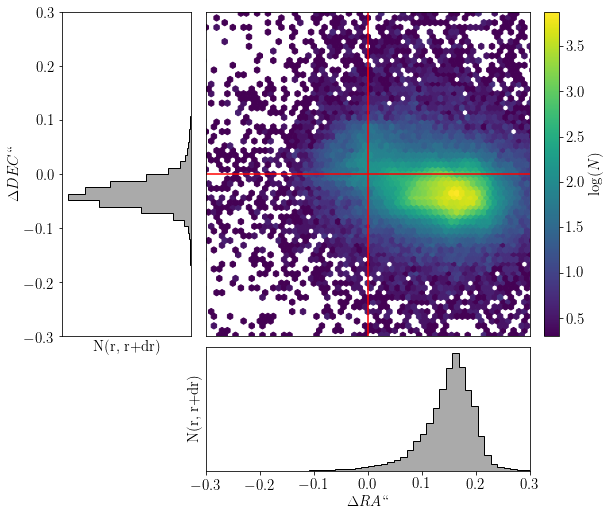

-36.4556985733
155.49195811
38.5494019497
70.0568769698


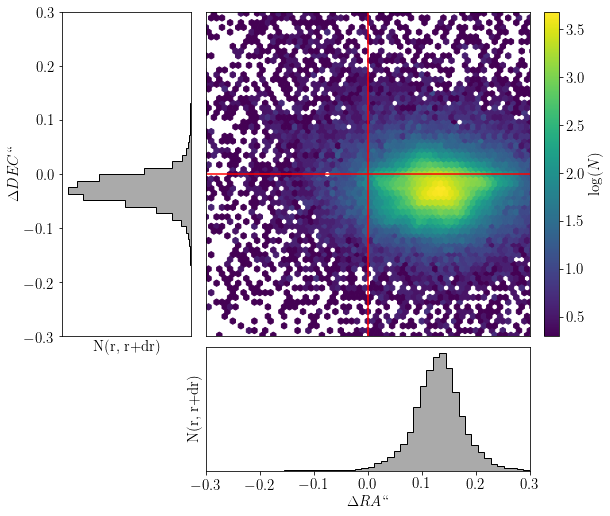

-27.5334285107
130.445366434
43.8833765378
72.8324049246


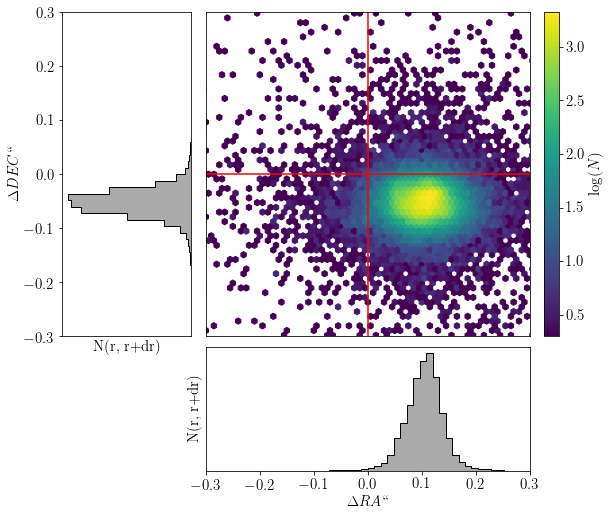

-51.7053702788
105.620830669
30.041781963
42.4885471422


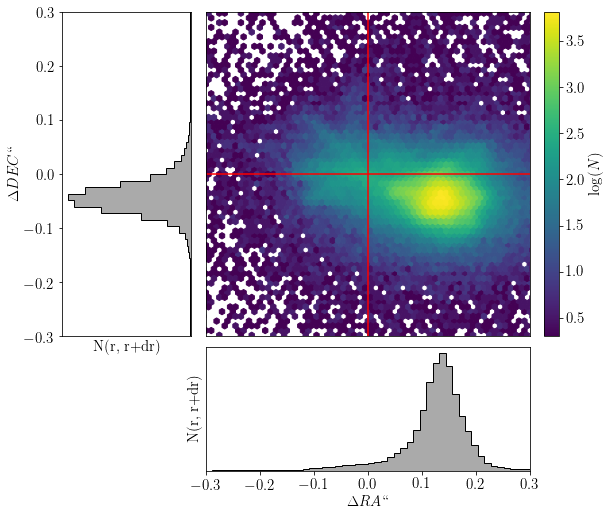

-42.6196541521
131.933611672
75.6829528857
138.576054425


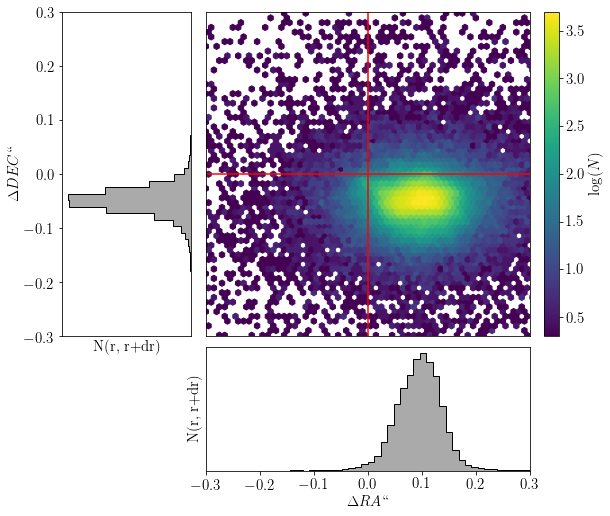

-47.9317768477
96.0084764229
36.5998649969
65.1673736494


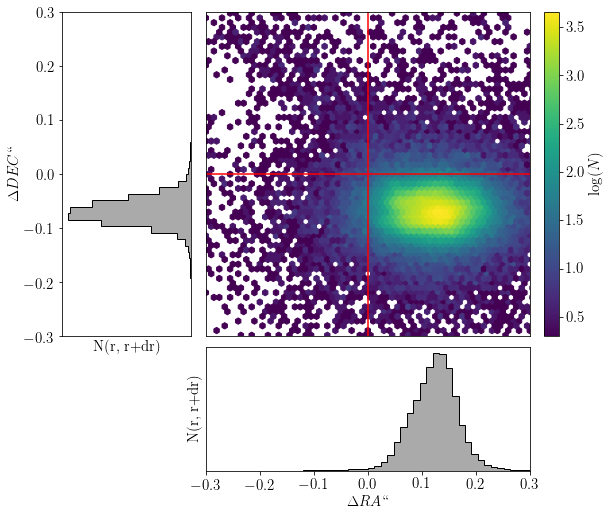

-68.9203360816
124.899687216
33.9898748316
59.5621233725


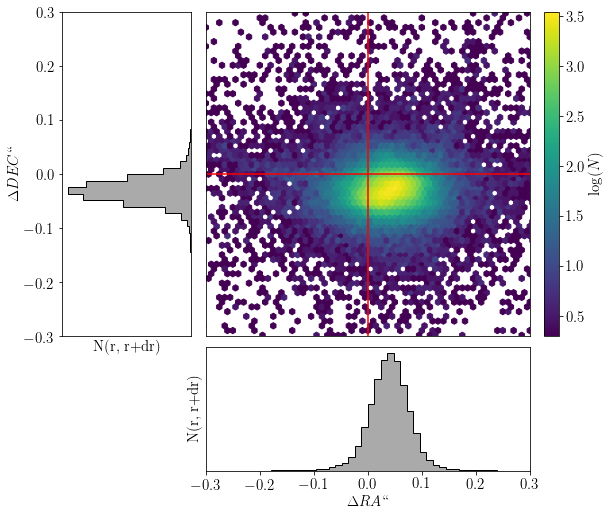

-29.8704852175
39.9854886055
29.7215132116
47.26032725


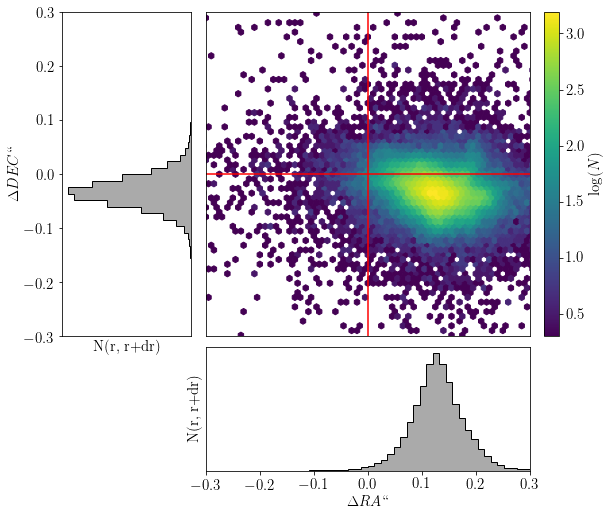

-32.3775922298
127.612626733
33.6659992538
54.8132342282


In [50]:
for visit in visit_info['visit_1']:
    decaps_lsst = Table.read('decaps-lsst-'+str(visit)+'.txt', format='ascii')

    #fname  = source+'-'+source+str(visit1)+'-'+str(visit2)+'.txt'
    #cat = Table.read(fname, format='ascii')
    
    decaps_coord = SkyCoord(ra = decaps_lsst['decaps_ra'].data, 
                         dec = decaps_lsst['decaps_dec'].data, 
                       unit='degree', frame='icrs')

    lsst_coord = SkyCoord(ra = decaps_lsst['lsst_ra']*u.radian, 
                          dec= decaps_lsst['lsst_dec']*u.radian)  

    dra = decaps_coord.ra.arcsec- lsst_coord.ra.arcsec
    ddec = decaps_coord.dec.arcsec-lsst_coord.dec.arcsec
    plot_dra_ddec(dra,ddec,visit)
    

In [11]:
#decaps_coord.dec.arcsec

array([-83218.15500932, -83151.62917756, -83033.33378179, ...,
       -89813.91292336, -89809.52229197, -89806.72472129])

(array([      0.,       0.,       0.,       0.,    7304.,  327953.,
              0.,       0.,       0.,       0.]),
 array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 <a list of 10 Patch objects>)

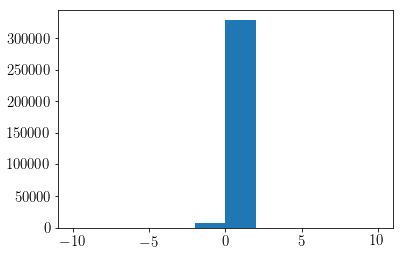

In [39]:
%matplotlib inline
plt.hist(dra[decaps_lsst['lsst_match'] == 1 ],range=(-10,10))

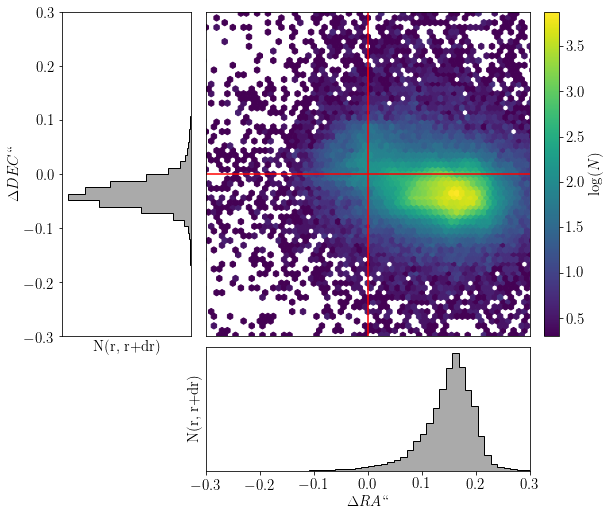

-36.4556985733
155.49195811
38.5494019497
70.0568769698
